In [130]:
!pip install pandas
!pip install openpyxl
!pip install plotly
!pip install matplotlib
!pip install numpy

In [129]:
import pandas as pd
import plotly.express as px
import numpy as np

In [52]:
df = pd.read_excel('data.xlsx', sheet_name='по странам чистый+22г', skiprows=1)
df

,Year,Number,Name,REITs Market Cap,GDP per Capita,GDP,Commercial Real Estate,Number of Companies,"Inflation rate,%"
0,2017,1,Belgium,14.52,43582.17,494.73,217.18,27.0,2.125971
1,2018,1,Belgium,15.00,43488.49,493.67,216.90,28.0,2.053165
2,2019,1,Belgium,21.29,46695.99,532.27,225.58,29.0,1.436820
3,2020,1,Belgium,23.16,43813.77,503.42,233.65,28.0,0.740792
4,2021,1,Belgium,29.16,44688.46,514.92,236.25,29.0,2.440249
...,...,...,...,...,...,...,...,...,...
61,2018,11,United States,996.94,59792.01,19485.40,8461.05,262.0,2.442583
62,2019,11,United States,1266.67,62868.92,20580.25,8844.03,249.0,1.812210
63,2020,11,United States,1206.00,63051.40,20807.27,9373.30,246.0,1.233584
64,2021,11,United States,1696.25,63358.49,20893.75,9370.20,237.0,4.697859


In [39]:
df['REITs Market Cap'] = df['REITs Market Cap'].astype(float)

In [41]:
fig = px.imshow(df.corr(numeric_only=True).abs(), color_continuous_scale='tempo')
fig.show()

Уберу признаки, имеющие кореляцию больше 0.9.

In [53]:
def get_corr_featueres(X, threshold=0.9):
    corr_featueres = []
    while True:
        corrs = (X.corr(numeric_only=True).abs() > threshold).sum()
        if corrs.max() == 1:
            return corr_featueres
        X = X.drop([corrs.idxmax()], axis=1)
        corr_featueres.append(corrs.idxmax())

        
corr_features = get_corr_featueres(df)
df = df.drop(corr_features, axis=1)
print('признаки имеющие большую кореляцию:', ', '.join(corr_features))

признаки имеющие большую кореляцию: GDP, Commercial Real Estate


In [57]:
for col in df.drop(['Year', 'Number', 'Name'], axis=1).columns:
    fig = px.box(df[col], title=col)
    
    fig.show()

По графикам видно, что свойства 'Number of Companies' и 'REITs Market Cup' имеют не нормальное распределение, также у них есть много выбросов сверху, предполагаю, что эти выбросы с
вязаны с тем, что эти выбросы составляют элементы с именем 'United States'.
Найду среднее значение этих свойств по странам, чтобы проверить эту гипотезу.

In [125]:
mean_by_country = df.groupby('Name').aggregate({'REITs Market Cap': 'mean', 'Number of Companies': 'mean'}).reset_index()

<Axes: xlabel='Name', ylabel='Number of Companies'>

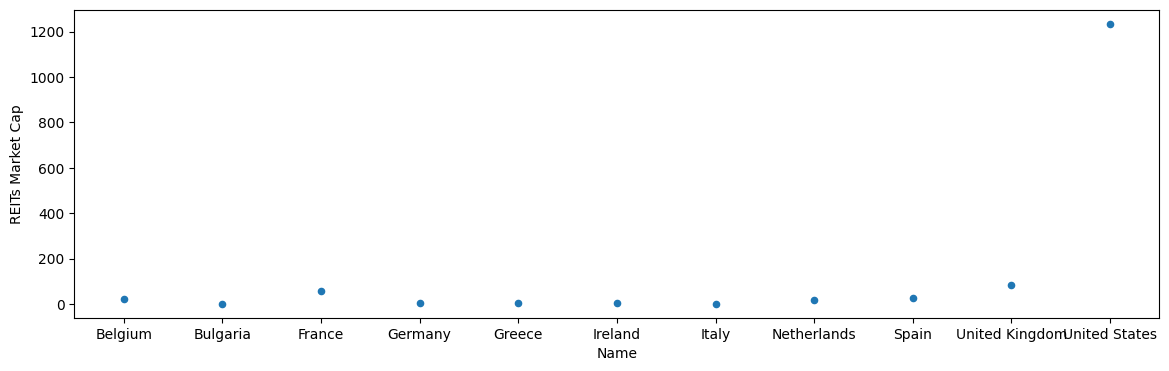

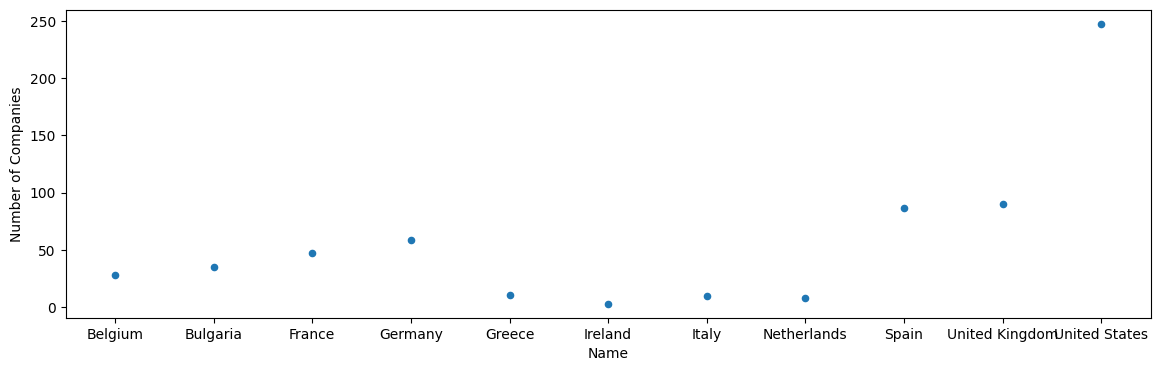

In [126]:
mean_by_country.plot.scatter(x='Name', y='REITs Market Cap', figsize=(14,4))
mean_by_country.plot.scatter(x='Name', y='Number of Companies', figsize=(14,4))

Действительно 'United States' имеют большое отклонения по этим свойствам, проверю какие будут распределения этох ведичин если исключить из выборки 'United States'.

In [127]:
for col in ['REITs Market Cap', 'Number of Companies']:
    fig = px.box(df[df.Name != 'United States'][col], title=col)
    fig.show()

Несмотря на то, что 'United States' был исключён, распределения остались с перекосом вниз, предположительно эти величины не должны иметь нормальное распределения из за экономоческого расслоения.
Поэтому я логарифмирую их.

In [132]:
df[['REITs Market Cap', 'Number of Companies']] = np.log(df[['REITs Market Cap', 'Number of Companies']])
df = df.rename(columns={'REITs Market Cap': 'log REITs Market Cap', 
                        'Number of Companies': 'log Number of Companies'})